In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [49]:
data = pd.read_csv("/content/AirPassengers.csv",index_col=['Month'])
data.head()


,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [8]:
ts = data['#Passengers']
ts.head()

Month
1949-01    112
1949-02    118
1949-03    132
1949-04    129
1949-05    121
Name: #Passengers, dtype: int64

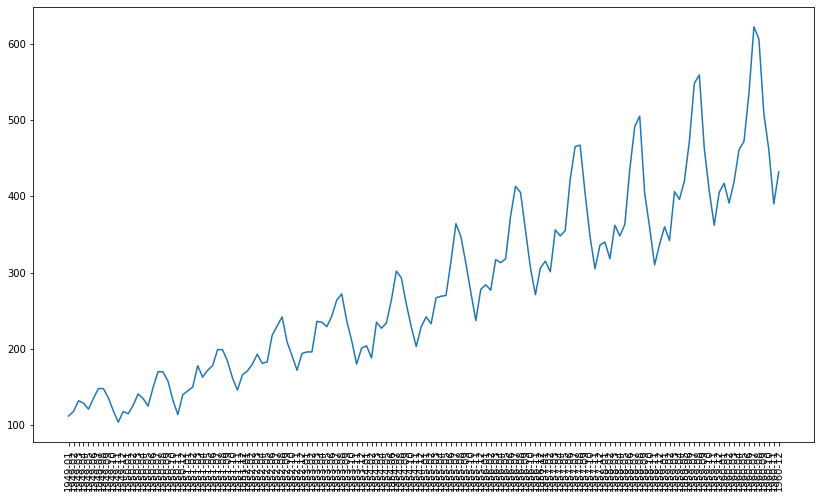

In [9]:
plt.figure(figsize=(14,8))
plt.xticks(rotation=90)
plt.plot(ts)

In [10]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
  plt.figure(figsize=(14,8))
  plt.xticks(rotation=90)
  roll = timeseries.rolling(window=12)
  rolmean = roll.mean()
  rolstd = roll.std()

  orig = plt.plot(timeseries,color='blue',label = "Original")
  mean = plt.plot(rolmean,color="red",label = "Rolling Mean")
  std =  plt.plot(rolstd,color="black", label = "Rolling Std")

  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

  print('Results of Dickey-Fuller Test:')

  dftest = adfuller(timeseries,autolag="AIC")

  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                           'Number of Observations Used'])
                       
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

  print(dfoutput)

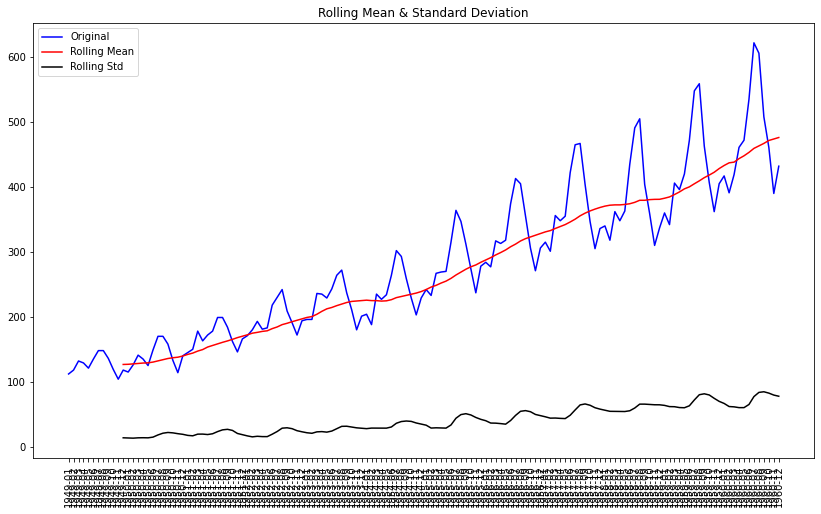

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [11]:
test_stationarity(ts)

##Estimating & Eliminating Trend

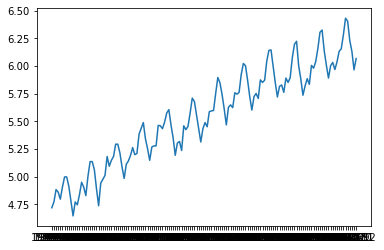

In [12]:
ts_log = np.log(ts)
plt.plot(ts_log)

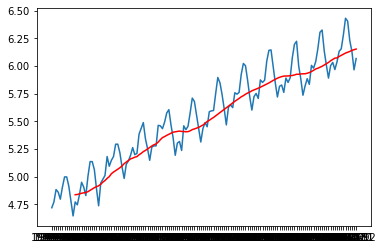

In [13]:
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg,color="red")

In [14]:
ts_log_moving_avg_diff = ts_log-moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01         NaN
1949-02         NaN
1949-03         NaN
1949-04         NaN
1949-05         NaN
1949-06         NaN
1949-07         NaN
1949-08         NaN
1949-09         NaN
1949-10         NaN
1949-11         NaN
1949-12   -0.065494
Name: #Passengers, dtype: float64

In [15]:
ts_log_moving_avg_diff.dropna(inplace=True)

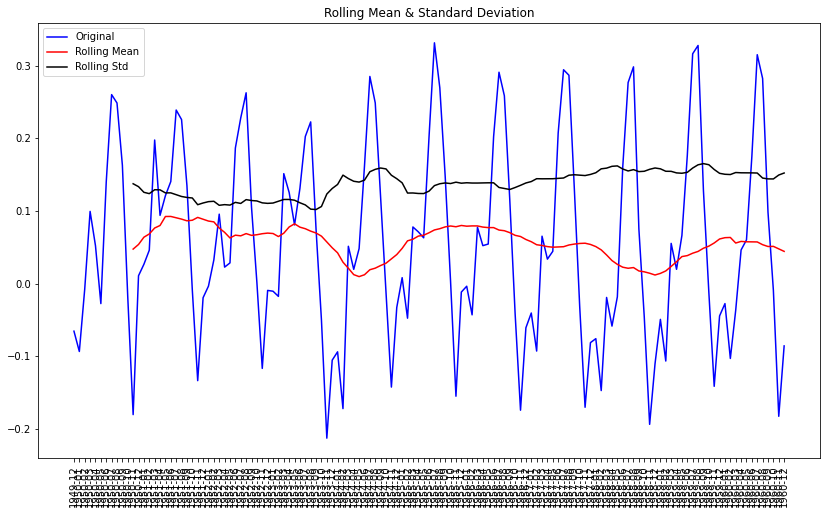

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [16]:
test_stationarity(ts_log_moving_avg_diff)

##exponentially weighted moving average

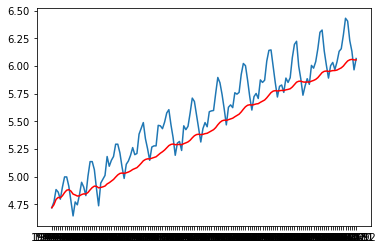

In [17]:
expwighted_avg = ts_log.ewm( halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

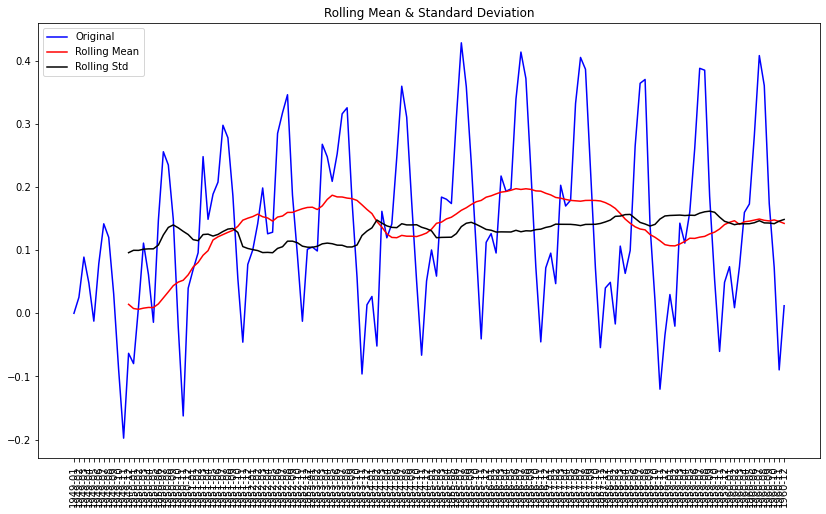

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [18]:
ts_log_ewma_diff = ts_log-expwighted_avg
test_stationarity(ts_log_ewma_diff)

##Eliminating Trend and Seasonality

###Differencing – taking the differece with a particular time lag

Trend ve Seasonality başa çıkmanın en yangın yöntemlerinden biri differencing yöntemidir. Bu yöntemde Belirli zamandaki gözlemin önceki zamandaki gözlem arasında farkı alınır.  

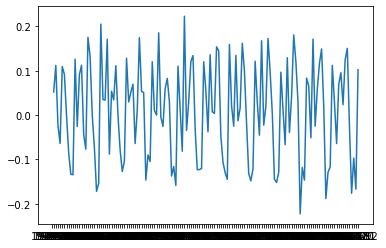

In [19]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

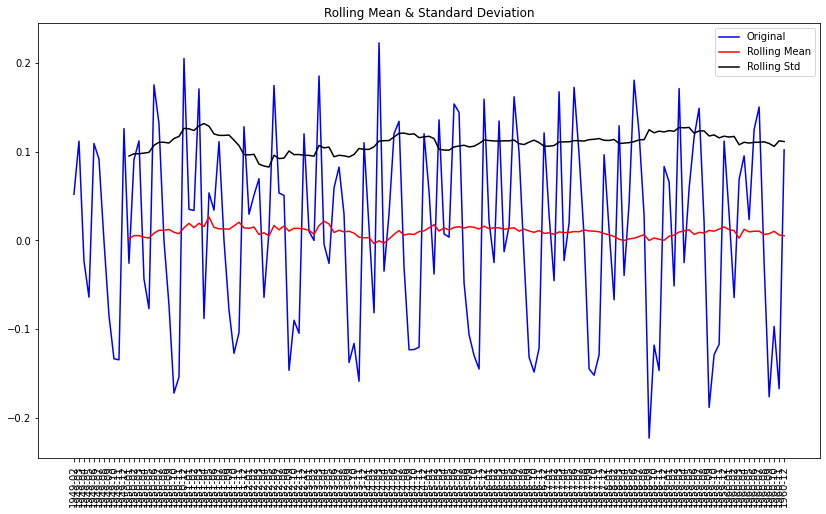

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [20]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

###Decomposing

Bu yöntemde trend ve seasonality ayrı ayrı modellenir.Kalan kısmı ise seriye geri döndürülür.

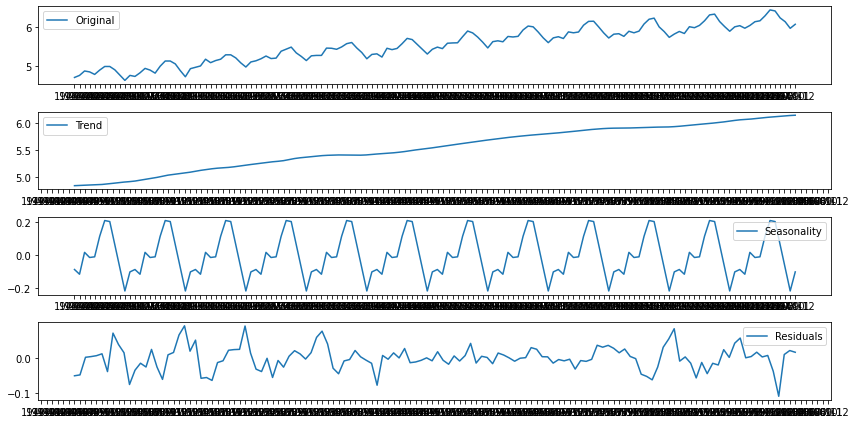

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompositional = seasonal_decompose(ts_log,freq=12)


trend = decompositional.trend
seasonal = decompositional.seasonal
residual = decompositional.resid

plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(ts_log,label = "Original")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()



Yukarıda trend ve seasonality ayrı olarak görebiliriz. Ayrıca residual ile ilgli model oluşturabiliriz.Residual stationarity(durağanlığı) test edelim.



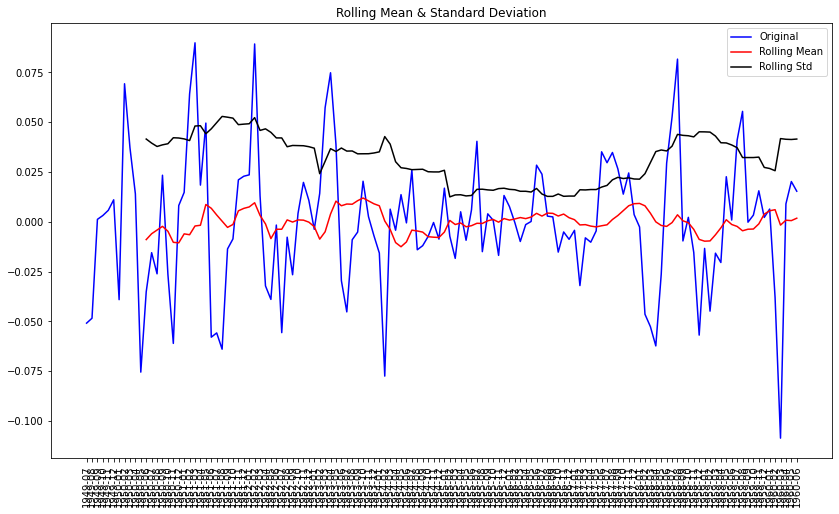

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [22]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

##Forecasting a Time Series

**ARIMA**

ARIMA 3 önemli parametreye sahiptir.(p,d,q)

1- Number of AR(Auto-Regressive) term(p) : Bağımlı değikenlerin gecikmesidir.Örneğin  p = 5 ise predictor x(t) = x(t-1)....x(t-5)

2- Number of MA (Moving Average) terms (q): MA terimleri tahmin denklemindeki geçikmeli tahmin hatalarıdır. q = 5 ise x(t) = e(t-1)...e(t-5) olacaktı. Burada e(i) i'inci andaki harektli ortalama ile gerçek değer arasındaki farktır.


3- Number of Differences (d): Bunlar sezon dışı farklılıkların sayısıdır, yani bu durumda birinci sıra farkı aldık. Yani ya bu değişkeni geçip d = 0 koyabiliriz ya da orijinal değişkeni geçip d = 1 koyabiliriz. Her ikisi de aynı sonuçları üretecek


Burada önemli olan p ve q nasıl belirlenir onu tartışma lazım .Bunun için 2 grafik incelememiz lazım

1-Autocorrelation Function (ACF):  Zaman serisinin gecikmeli versiyonun arasındaki korelasyon ölçüsüdür.  Örneğin ACF t1 ve t2 anındaki seriyi 5 gecikmede incelerken t1-5 ve t2-5 serileri ile karşılaştırılır.

2- Partial Autocorrelation Function (PACF):  Zaman serisinin kendisinin gecikmeli versiyonu ile araasındaki koralesyonu ölçer.


In [23]:
from statsmodels.tsa.stattools import acf,pacf

In [29]:
lag_acf = acf(ts_log_diff,nlags=20)
lag_pacf = pacf(ts_log_diff,nlags=20,method="ols")

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


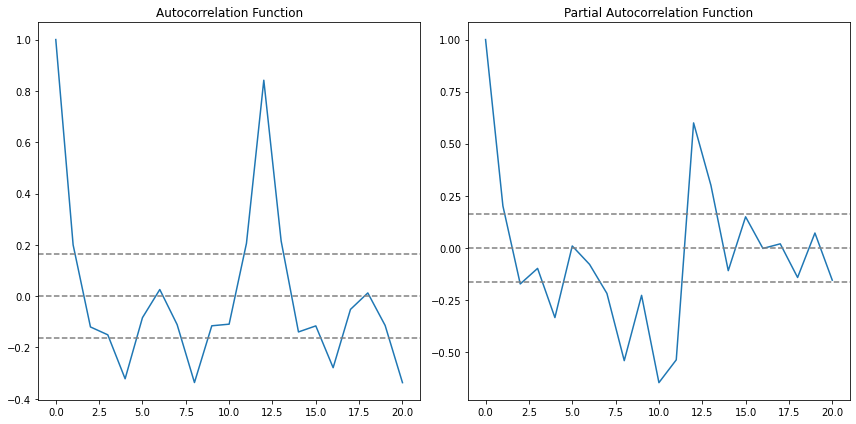

In [30]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle="--",color="gray")
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Yukarıda -1.96 be 1.96 cizgileri güven aralıklarıdır. Bunlar p ve q değişkenlerini belirlemek için şu şekilde kullanılabilir.

1- p değeri için PACF güven aralığını ilk kez geçtiği en yakın p = 2 'dir

2- q değeri ACF grafiğinde geçtiği ilkk değer 2 olarak varsayıyoruz. q = 2

In [31]:
from statsmodels.tsa.arima_model import ARIMA

##AR Model


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5023')

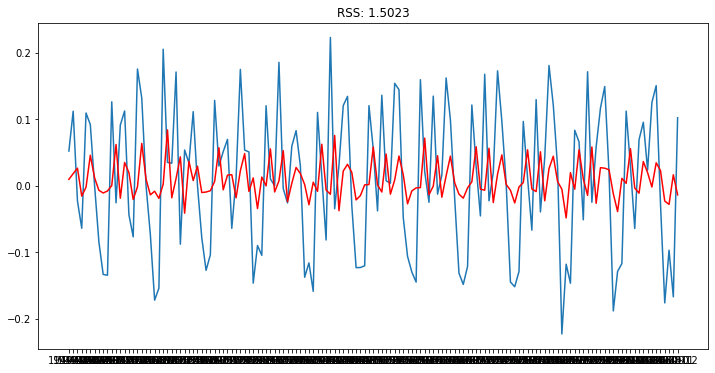

In [37]:

plt.figure(figsize=(12,6))
model = ARIMA(ts_log,order=(2,1,0))
results_AR= model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues,color="red")
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))



##MA Model

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.4721')

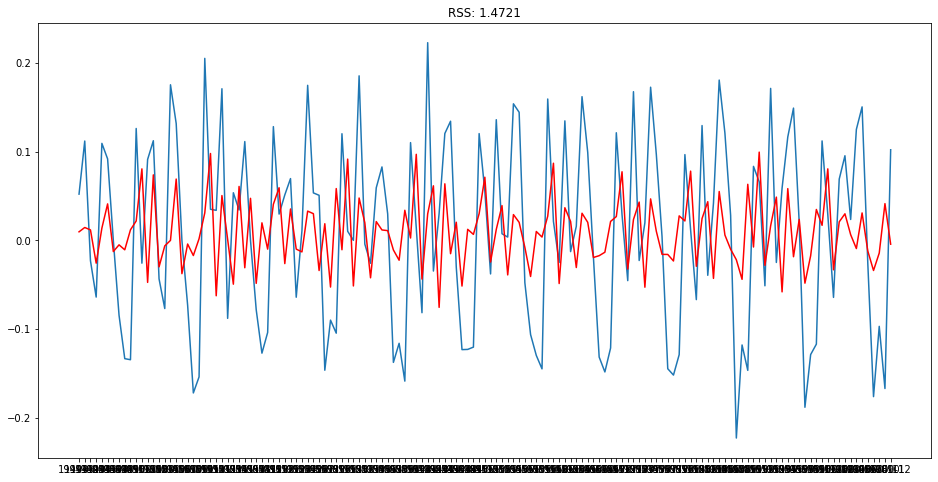

In [40]:
plt.figure(figsize=(16,8))
model = ARIMA(ts_log,order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color="red")
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

##ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

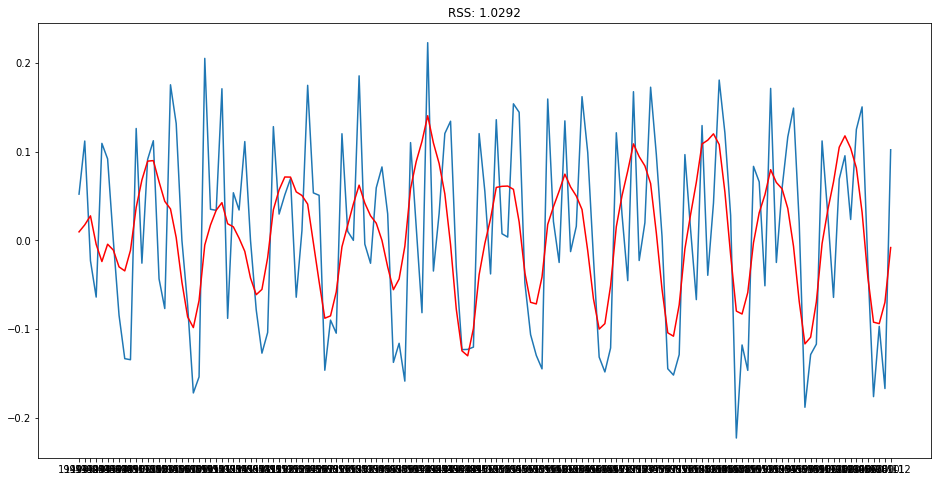

In [43]:
plt.figure(figsize=(16,8))
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

##Tahminlerin Performans Ölçümü

In [44]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
predictions_ARIMA_diff.head()

Month
1949-02    0.009580
1949-03    0.017491
1949-04    0.027670
1949-05   -0.004521
1949-06   -0.023890
dtype: float64

In [46]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())


Month
1949-02    0.009580
1949-03    0.027071
1949-04    0.054742
1949-05    0.050221
1949-06    0.026331
dtype: float64


In [50]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0],index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()


Month
1949-01    4.718499
1949-02    4.728079
1949-03    4.745570
1949-04    4.773241
1949-05    4.768720
dtype: float64

Text(0.5, 1.0, 'RMSE: 90.1046')

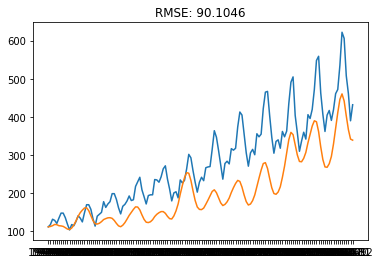

In [51]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))